## Notebook example of ptychograpic reconstruction on simulated data

This is a basic example, showing how to:
* simulate data
* compute the object shape from the data
* use the Ptycho operators for reconstruction

In [1]:
# Optional: select language and/or GPU name or rank through environment variable
# import os
# os.environ['PYNX_PU'] = 'cuda'

%matplotlib notebook
import matplotlib.pyplot as plt
from pynx.ptycho import simulation, shape

# Import Ptycho, PtychoData and operators (automatically selecting OpenCL or CUDA)
from pynx.ptycho import *

## Simulate the Ptychography dataset

In [2]:
# 2D detector size (square)
nxy = 256
# Pixel size in meters
pixel_size_detector = 55e-6
# Wavelength in meters
wavelength = 1.5e-10
# Detector distance in meters
detector_distance = 1

# Object options 'siemens' simulates Siemens star (with a few holes)
# 'logo' simulates PyNX logo
# obj_info = {'type': 'logo', 'phase_stretch': 1.57, 'alpha_win': .2}
obj_info = {'type': 'siemens', 'phase_stretch': 1.57, 'alpha_win': .2}

# Probe description, either as a Gaussian, or as a focused aperture
probe_info = {'type': 'focus', 'aperture': (150e-6, 150e-6), 'focal_length': .08,
              'defocus': 350e-6, 'shape': (nxy, nxy)}
# probe_info = {'type': 'gauss', 'sigma_pix': (20, 20), 'shape': (nxy, nxy)}

# Spiral scan: 50 positions = 4 turns, 78 = 5 turns, 113 = 6 turns
scan_info = {'type': 'spiral', 'scan_step_pix': 20, 'n_scans': 200}

# Data info, with the different parameters and using Poisson noise
# nb_photons_per_frame is the average number of photons per frame
data_info = {'nb_photons_per_frame': 1e9, 'bg': 0, 'wavelength': wavelength,
             'detector_distance': detector_distance,
             'detector_pixel_size': pixel_size_detector,
             'noise': 'poisson'}

# Initialisation of the simulation
s = simulation.Simulation(obj_info=obj_info, probe_info=probe_info, scan_info=scan_info, data_info=data_info)
s.make_data()
posx, posy = s.scan.values
pixel_size_object = wavelength * detector_distance / pixel_size_detector / nxy
ampl = s.amplitude.values  # square root of the measured diffraction pattern intensity


Simulating object: siemens
Simulating probe: focus
Simulating scan: spiral
Simulating ptychographic data [200 frames].


Parameters of the simulation:
Data info: {'pix_size_direct_nm': 10, 'num_phot_max': None, 'nb_photons_per_frame': 1000000000.0, 'bg': 0, 'beam_stop_transparency': 0, 'noise': 'poisson', 'wavelength': 1.5e-10, 'detector_distance': 1, 'detector_pixel_size': 5.5e-05}
Scan info: {'type': 'spiral', 'scan_step_pix': 20, 'n_scans': 200, 'integer_values': True}
Object info: {'type': 'Custom', 'phase_stretch': 1.57, 'alpha_win': 0.2}
Probe info: {'type': 'focus', 'shape': (256, 256), 'sigma_pix': (50, 50), 'rotation': 0, 'aperture': (0.00015, 0.00015), 'focal_length': 0.08, 'defocus': 0.00035}


## Prepare the initial object and probe
This uses the `pynx.ptycho.simulation` module for an explicit simulation of object and probe.

Note that if the initial object array is not supplied to the `Ptycho`object (`obj=None`), its size will be automatically calculated, and the object initialised to an homogeneous object (array of 1)

In [3]:
# Size of the reconstructed object
nyo, nxo = shape.calc_obj_shape(posx, posy, ampl.shape[1:])

# Initial object
obj_init_info = {'type': 'random', 'range': (0.9, 1, 0, 0.5), 'shape': (nyo, nxo)}

# Initial probe
probe_init_info = {'type': 'focus', 'aperture': (150e-6, 150e-6), 'focal_length': .08,
              'defocus': 250e-6, 'shape': (nxy, nxy)}

# Basic data info, used to compute the object pixel size
data_info = {'wavelength': wavelength, 'detector_distance': detector_distance,
             'detector_pixel_size': pixel_size_detector}
# Perform the actual simulation
init = simulation.Simulation(obj_info=obj_init_info, probe_info=probe_init_info, data_info=data_info)
init.make_obj()
init.make_probe()

Simulating object: random
Simulating probe: focus


## Create the `PtychoData` and `Ptycho` objects

In [4]:
data = PtychoData(iobs=ampl ** 2, positions=(posx * pixel_size_object, posy * pixel_size_object), 
                  detector_distance=1, mask=None, pixel_size_detector=55e-6, wavelength=1.5e-10)

# Random object start
p = Ptycho(probe=init.probe.values, obj=init.obj.values, data=data, background=None) 

# Initial scaling of object and probe
p = ScaleObjProbe(verbose=True) * p

ScaleObjProbe: 3191.7024 328451.0 3.7129252805372284 19.547093968788563 0.18994768381319133


## Optimise the Ptycho object 
This can use different algorithms:
* Difference Map
* Alternating Projections
* Maximum Likelihood conjugate gradient

For each algorithm it is possible to update object, probe, positions, and to display the result.

Each algorithm operator is elevated to the the number of cycles, e.g. `DM()**40` will perform 40 cycles

<IPython.core.display.Javascript object>


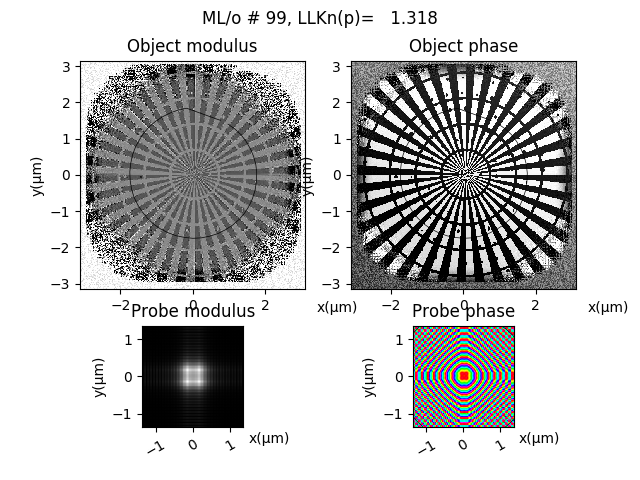

DM/o/p     #  0 LLK=  3410.75(p) 11625.04(g)  5291.49(e), nb photons=1.794479e+11, dt/cycle=0.000s
DM/o/p     # 10 LLK=   448.10(p)   420.28(g)   616.58(e), nb photons=1.935150e+11, dt/cycle=0.048s
DM/o/p     # 20 LLK=    99.37(p)   103.95(g)   144.18(e), nb photons=1.984663e+11, dt/cycle=0.038s
DM/o/p     # 30 LLK=    48.29(p)    50.13(g)    71.51(e), nb photons=1.991721e+11, dt/cycle=0.038s
DM/o/p     # 40 LLK=     8.22(p)    11.43(g)    14.02(e), nb photons=1.997212e+11, dt/cycle=0.041s
DM/o/p     # 50 LLK=     1.19(p)     2.30(g)     2.37(e), nb photons=1.999045e+11, dt/cycle=0.037s
DM/o/p     # 60 LLK=     1.17(p)     2.22(g)     2.31(e), nb photons=1.998823e+11, dt/cycle=0.037s
DM/o/p     # 70 LLK=     1.13(p)     2.12(g)     2.23(e), nb photons=1.998428e+11, dt/cycle=0.037s
DM/o/p     # 80 LLK=     0.93(p)     1.72(g)     1.83(e), nb photons=1.998343e+11, dt/cycle=0.037s
DM/o/p     # 90 LLK=     1.17(p)     2.17(g)     2.31(e), nb photons=1.998112e+11, dt/cycle=0.037s
DM/o/p    

In [5]:
plt.figure()
p = DM(update_object=True, update_probe=True, calc_llk=10, show_obj_probe=10)**200 * p
#p = ShowObjProbe() * AP(update_object=True, update_probe=False, calc_llk=10)**40 * p
p = ML(update_object=True, update_probe=False, calc_llk=20, show_obj_probe=20)**100 * p

## Use DM and ML options to smooth the object and/or probe
For DM or AP, use the `*_smooth_sigma` and `*_inertia` parameters
For ML, use the `reg_fac_*` parameters to 

<IPython.core.display.Javascript object>


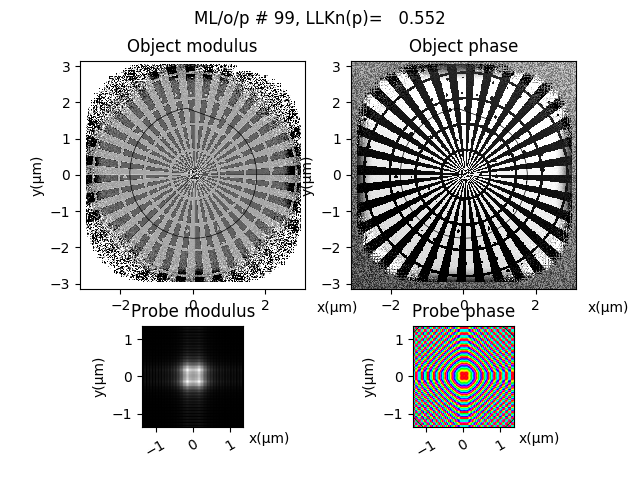

DM/o/p     #301 LLK=     0.99(p)     2.02(g)     1.99(e), nb photons=1.999920e+11, dt/cycle=0.252s
DM/o/p     #311 LLK=     0.61(p)     1.20(g)     1.22(e), nb photons=1.999781e+11, dt/cycle=0.038s
DM/o/p     #321 LLK=     0.63(p)     1.21(g)     1.26(e), nb photons=1.999402e+11, dt/cycle=0.037s
DM/o/p     #331 LLK=     0.70(p)     1.32(g)     1.39(e), nb photons=1.999062e+11, dt/cycle=0.036s
DM/o/p     #340 LLK=     0.76(p)     1.42(g)     1.51(e), nb photons=1.998789e+11, dt/cycle=0.039s
ML/o/p     #342 LLK=     0.55(p)     1.09(g)     1.11(e), nb photons=1.999908e+11, dt/cycle=0.203s
ML/o/p     #362 LLK=     0.55(p)     1.09(g)     1.11(e), nb photons=2.000014e+11, dt/cycle=0.034s
ML/o/p     #382 LLK=     0.55(p)     1.09(g)     1.11(e), nb photons=2.000014e+11, dt/cycle=0.032s
ML/o/p     #402 LLK=     0.55(p)     1.09(g)     1.11(e), nb photons=2.000014e+11, dt/cycle=0.033s
ML/o/p     #422 LLK=     0.55(p)     1.09(g)     1.11(e), nb photons=2.000014e+11, dt/cycle=0.033s
ML/o/p    

In [6]:
plt.figure()  # Create a new figure instead of using the one in the previous cell
p = DM(update_object=True, update_probe=True, calc_llk=10, show_obj_probe=10,
       obj_smooth_sigma=0.1, obj_inertia=0.01, probe_smooth_sigma=0.05, probe_inertia=0.001)**40 * p

p = ML(update_object=True, update_probe=True, show_obj_probe=20,
       calc_llk=20, reg_fac_obj=0.01, reg_fac_probe=0)**100 * p


## Add probe modes and continue optimising
The `DM/o/3p` indicates:
* the algorithm (DM or AP or ML)
* the parts which are optimised (o for object, p for probe, t for translations)
* the number of modes (when >1)

<IPython.core.display.Javascript object>


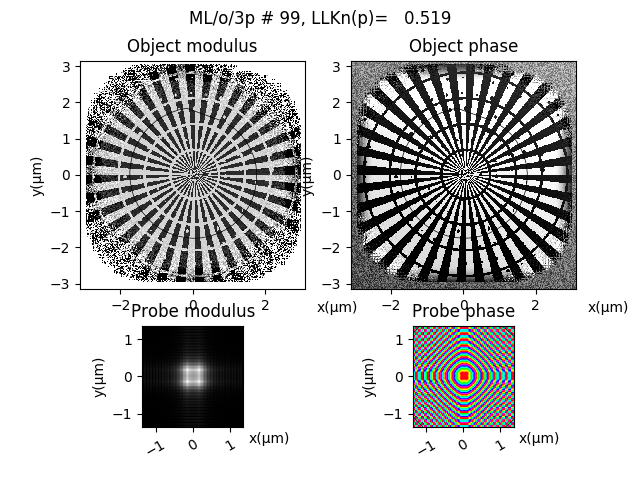

DM/o/3p    #442 LLK=     1.55(p)     6.58(g)     3.54(e), nb photons=1.999861e+11, dt/cycle=0.267s
DM/o/3p    #452 LLK=     0.52(p)     1.04(g)     1.05(e), nb photons=1.999844e+11, dt/cycle=0.044s
DM/o/3p    #462 LLK=     0.59(p)     1.12(g)     1.17(e), nb photons=1.999413e+11, dt/cycle=0.044s
DM/o/3p    #472 LLK=     0.66(p)     1.25(g)     1.31(e), nb photons=1.999067e+11, dt/cycle=0.043s
DM/o/3p    #481 LLK=     0.74(p)     1.38(g)     1.46(e), nb photons=1.998774e+11, dt/cycle=0.044s
ML/o/3p    #483 LLK=     0.54(p)     1.05(g)     1.07(e), nb photons=1.999910e+11, dt/cycle=0.142s
ML/o/3p    #503 LLK=     0.53(p)     1.04(g)     1.06(e), nb photons=1.999989e+11, dt/cycle=0.057s
ML/o/3p    #523 LLK=     0.52(p)     1.04(g)     1.05(e), nb photons=1.999956e+11, dt/cycle=0.057s
ML/o/3p    #543 LLK=     0.52(p)     1.04(g)     1.05(e), nb photons=1.999984e+11, dt/cycle=0.057s
ML/o/3p    #563 LLK=     0.52(p)     1.04(g)     1.05(e), nb photons=1.999991e+11, dt/cycle=0.057s
ML/o/3p   

In [7]:
pr = p.get_probe()
nb_probe, ny, nx = pr.shape
# New number of probe modes
nb_probe = 3 
pr1 = np.empty((nb_probe, ny, nx), dtype=np.complex64)
pr1[0] = pr[0]
for i in range(1, nb_probe):
    n = abs(pr).mean() / 10
    pr1[i] = np.random.uniform(0, n, (ny, nx)) * np.exp(1j * np.random.uniform(0,2*np.pi, (ny,nx)))

p.set_probe(pr1)

plt.figure()
p = DM(update_object=True, update_probe=True, calc_llk=10, show_obj_probe=10)**40 * p
p = ML(update_object=True, update_probe=True, calc_llk=20, show_obj_probe=20)**100 * p


In [8]:
# Manual decompositon of algorithms
#p = Psi2Obj() * PropagateApplyAmplitude()* ObjProbe2Psi() * SelectStack(0) * p
#p = Psi2ObjMerge() * LoopStack(Psi2Obj() * PropagateApplyAmplitude() * ObjProbe2Psi()) * p

## Export data and/or result object & probe to CXI (hdf5) files

In [9]:
if False:
    # 
    p.save_obj_probe_cxi('obj_probe.cxi')
    save_ptycho_data_cxi('data.cxi', ampl ** 2, pixel_size_detector, wavelength, detector_distance,
                         posx * pixel_size_object, posy * pixel_size_object, z=None, monitor=None,
                         mask=None, instrument='simulation', overwrite=True)
